<a href="https://colab.research.google.com/github/sipocz/Zindi_plastic/blob/main/Image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
import ee
import geemap
import PIL
import pandas
from google.colab import drive

In [151]:
_DEBUG_=False
_PROJECT_IMAGE_BASE_='/content/drive/MyDrive/Zindi_Plastic_images_infra/'
_IMAGES_='images'
_PROJECT_FILES_BASE_='/content/drive/MyDrive/Zindi_Plastic_images/'
_TEST_IMAGES_='test_images'

_ORIG_='orig'


In [135]:
ee.Authenticate()
ee.Initialize(project='zindiplasticproject')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
def add_time(image):
  return image.addBands(image.getNumber('system:time_start'))

In [137]:
def conditional(image):
  return ee.Algorithms.If(
      ee.Number(image.get('SUN_ELEVATION')).gt(40), image, ee.Image(0)
  )


In [138]:
def gamma_correct(gamma, path):
    """

    Args:
      gamma: selected gamma value
      path: the path of the image

    Returns: gamma corrected image

    """
    im = PIL.Image.open(path)
    gamma1 = gamma
    row = im.size[0]
    col = im.size[1]
    result_img1 = PIL.Image.new(mode="RGB", size=(row, col), color=0)
    for x in range(row):
        for y in range(col):
            r = pow(im.getpixel((x, y))[0] / 255, (1 / gamma1)) * 255
            g = pow(im.getpixel((x, y))[1] / 255, (1 / gamma1)) * 255
            b = pow(im.getpixel((x, y))[2] / 255, (1 / gamma1)) * 255
            # add
            color = (int(r), int(g), int(b))
            result_img1.putpixel((x, y), color)
    #show
    return result_img1

In [139]:
def image_download(index=int,longitude=float,latitude=float,place=str,sat=None,band=None,sdate="2024-04-15",edate="2024-04-17"):
    from math import gamma
    import geemap
    import ee

    # Google Earth Engine inicializálása
    ee.Initialize()

    if sat==None:
        sat='COPERNICUS/S2_SR_HARMONIZED'
    if band==None:
        band=['B11','B12','B8']

    # 1000 méteres körzet létrehozása Budapest középpontjában
    point = ee.Geometry.Point([longitude, latitude])
    buffer = point.buffer(10).bounds()  # 1000 méteres buffer

    # Sentinel-2 műholdkép lekérése nappali időszakban
    collection = ee.ImageCollection(sat) \
        .filterBounds(buffer) \
        .filterDate(sdate, edate) \
        .sort('CLOUDY_PIXEL_PERCENTAGE')  # Legkevésbé felhős kép kiválasztása
    first_image = collection.first()  # Az első legkevésbé felhős kép

    # Ellenőrizd, hogy az első kép érvényes
    if first_image is None:
        raise ValueError("Nem találtunk érvényes képet a megadott időszakban.")

    # Kép RGB sávok kiválasztása
    image = first_image.select(band)  # Red, Green, Blue
    import matplotlib.pyplot as plt

    aoi=ee.Geometry.Rectangle(longitude-0.005,latitude-0.005,longitude+0.005,latitude+0.005 )


    rgb_img = geemap.ee_to_numpy(image,region=aoi)
    if _DEBUG_==True:
        print(rgb_img.shape)

    max_p=15448 #rgb_img[:,:,2].max()

    rgb_img_test = (255 * ((rgb_img[:, :, 0:3] ) / max_p)).astype("uint8")

    if _DEBUG_==True:
        print(rgb_img[:,:,2].max())


    img=PIL.Image.fromarray(rgb_img_test)

    img=img.resize((192,192))
    return img


In [140]:
_DEBUG_=True

In [141]:
pil_image=image_download(20,37.05635887,0.053674338,"Kenya",sat="COPERNICUS/S2_SR_HARMONIZED",band=['B7','B8','B8A'],sdate="2024-04-14",edate="2024-05-04")

(56, 56, 3)
15051


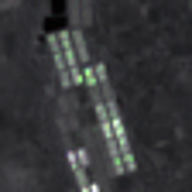

In [142]:
pil_image

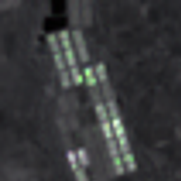

In [143]:
pil_image.crop((0,0,181,181))


In [98]:
image_download(20,37.05635887,0.053674338,"Kenya")

Exception: Image.select: Parameter 'input' is required.

In [144]:

df_kenya=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Kenya_training.csv")


In [145]:
df_kenya.head()

,ID,lon,lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,37.059054,0.046039,2731.0,3035.0,5418.0,5306.5,2958.0,4610.5,5099.5,2994.0,4108.5,3187.5,-6.861458,-12.162713,1
1,2,37.059503,0.047296,2921.0,3329.0,5834.0,6472.0,4144.5,5782.0,6302.0,3344.0,5269.0,4471.5,-8.082717,-14.619608,1
2,3,37.057527,0.047656,3828.0,4163.0,6420.0,7890.5,5408.5,6695.5,7302.0,4380.0,6905.0,6905.5,-7.767043,-14.880353,1
3,4,37.057976,0.047925,2556.0,2839.0,4822.0,5276.5,3201.0,4643.0,5069.5,2787.0,3832.0,2867.5,-7.773118,-15.587653,1
4,5,37.056359,0.048554,3790.0,4009.0,6476.0,6199.5,4285.0,5711.0,6079.5,3939.0,4892.5,3702.5,-6.104467,-15.431915,1


In [147]:
def image_generation(df,image_id):
    for i,row in df.iterrows():
        image=image_download(row.ID,row.lon,row.lat,image_id,sat=_sat_,band=_band_,sdate="2024-04-14",edate="2024-05-04")
        image.save(_PROJECT_IMAGE_BASE_+_IMAGES_+"/"+str(int(row.ID))+'_'+str(int(row.TARGET))+"_"+image_id+".jpg")
        print(str(i).rjust(3,'0'),end=".")
        if i % 20==0:
            print("*")

In [148]:
_sat_=None
_band_=None
_image_id_="kenya"

In [152]:
image_generation(df_kenya,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

532.533.534.535.536.537.538.539.540.*
541.542.543.544.545.546.547.548.549.550.551.552.553.554.555.556.557.558.559.560.*
561.562.563.564.565.566.567.568.569.570.571.572.573.574.575.576.577.578.579.580.*
581.582.583.584.585.586.587.588.589.590.591.592.593.594.595.596.597.598.599.600.*
601.602.603.604.605.606.607.608.609.610.611.612.613.614.615.616.617.618.619.620.*
621.622.623.624.625.626.627.628.629.630.631.632.633.634.635.636.637.638.639.640.*
641.642.643.644.645.646.647.648.649.650.651.652.653.654.655.656.657.658.659.660.*
661.662.663.664.665.666.667.668.669.670.671.672.673.674.675.676.677.678.679.680.*
681.682.683.684.685.686.687.688.689.690.691.692.693.694.695.696.697.698.699.700.*
701.702.703.704.705.706.707.708.709.710.711.712.713.714.715.716.717.718.719.720.*
721.722.723.724.725.726.727.728.729.730.731.732.733.734.735.736.737.738.739.740.*
741.742.743.744.745.746.747.748.749.750.751.752.753.754.755.756.757.758.759.760.*
761.762.763.764.765.766.767.768.769.770.771.772.773.774.775.

In [153]:
df_spain=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Spain_training.csv")
_image_id_="spain"

In [154]:
image_generation(df_spain,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [155]:
df_vnm=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/VNM_training.csv")
_image_id_="vnm"

In [156]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1


In [157]:
df_vnm['lon']=df_vnm["Lon"]
df_vnm['lat']=df_vnm["Lat"]

In [158]:
image_generation(df_vnm,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [159]:
df_vnm.head()

,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.307403,11.706890,1772.5,2081.5,4393.0,4322.0,2542.0,3974.5,4315.0,1901.5,2929.5,2324.0,-5.506588,-16.577070,1,108.307403,11.706890
1,2,108.363279,11.778036,2178.0,2347.0,3427.0,3712.0,2658.5,3358.0,3628.5,2313.0,3122.0,2729.5,-7.798610,-14.007271,1,108.363279,11.778036
2,3,108.193946,11.689462,2927.0,3107.0,4365.0,4624.5,3378.0,4221.5,4508.5,3082.0,3921.0,3190.0,-7.652615,-14.319975,1,108.193946,11.689462
3,4,108.200324,11.691618,2175.0,2312.0,3472.5,3613.5,2569.5,3332.0,3558.5,2244.0,3132.5,2610.0,-9.530750,-16.471949,1,108.200324,11.691618
4,5,108.203109,11.694313,2125.0,2235.0,2612.0,2960.0,2548.5,2801.0,2908.0,2320.0,2915.0,2685.5,-9.733130,-18.106146,1,108.203109,11.694313


In [160]:
df_spain_test=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Spain_validation.csv")
_image_id_="_spain_testing"
_sat_=None
_band_=None
df_spain_test["TARGET"]=0

In [161]:
image_generation(df_spain_test,_image_id_)


000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [162]:
df_vnm_test=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/VNM_testing.csv")
_image_id_="_vnm_testing"
_sat_=None
_band_=None
df_vnm_test["TARGET"]=0
df_vnm_test["lon"]=df_vnm_test["Lon"]
df_vnm_test["lat"]=df_vnm_test["Lat"]

In [163]:
df_vnm_test.head()


,ID,Lon,Lat,blue_p50,green_p50,nir_p50,nira_p50,re1_p50,re2_p50,re3_p50,red_p50,swir1_p50,swir2_p50,VV_p50,VH_p50,TARGET,lon,lat
0,1,108.406667,11.699973,2284.0,2429.0,2857.0,3314.5,2690.5,3043.5,3165.0,2461.0,3385.5,2848.0,-9.688691,-17.492636,0,108.406667,11.699973
1,2,108.364087,11.780641,2606.0,2743.0,3708.0,4164.0,3226.5,3826.5,4080.5,2819.0,3978.5,3402.0,-8.679594,-16.148212,0,108.364087,11.780641
2,3,108.201133,11.690091,1965.0,2174.0,3713.0,3767.0,2475.5,3473.5,3750.5,2050.0,2870.5,2309.0,-7.793950,-14.815912,0,108.201133,11.690091
3,4,108.196731,11.692157,2010.0,2051.0,2401.0,2510.0,2234.0,2448.0,2532.0,2106.0,2476.5,2137.0,-9.485932,-15.773308,0,108.196731,11.692157
4,5,108.197809,11.695032,2084.0,2253.0,3148.0,3371.0,2628.0,3212.5,3369.0,2301.0,3226.0,2874.0,-7.751073,-16.848070,0,108.197809,11.695032


In [164]:
image_generation(df_vnm_test,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [165]:
df_kenya_test=pandas.read_csv(_PROJECT_FILES_BASE_+_ORIG_+"/Kenya_testing.csv")
_image_id_="_kenya_testing"
_sat_=None
_band_=None
df_kenya_test["TARGET"]=0


In [166]:
image_generation(df_kenya_test,_image_id_)

000.*
001.002.003.004.005.006.007.008.009.010.011.012.013.014.015.016.017.018.019.020.*
021.022.023.024.025.026.027.028.029.030.031.032.033.034.035.036.037.038.039.040.*
041.042.043.044.045.046.047.048.049.050.051.052.053.054.055.056.057.058.059.060.*
061.062.063.064.065.066.067.068.069.070.071.072.073.074.075.076.077.078.079.080.*
081.082.083.084.085.086.087.088.089.090.091.092.093.094.095.096.097.098.099.100.*
101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.*
121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.*
141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.*
161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.*
181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.*
201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.*
221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.*
241.242.24

In [167]:

# _sat_="LANDSAT/LC08/C02/T1_L2"
# _band_=['SR_B7','SR_B3','SR_B2']
# _image_id_="_kenya_landsat"

In [168]:
# image_generation(df_kenya,_image_id_)

In [169]:
def format_image(image_dir):
    image = tf.read_file(image_dir)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_image_with_pad(image, 256, 256, align_corners=True)
    return image

In [179]:
test_images_dir=_PROJECT_IMAGE_BASE_+_TEST_IMAGES_
images_dir=_PROJECT_IMAGE_BASE_+_IMAGES_

In [180]:
!mv {images_dir+'/*_1_*.jpg'} {images_dir+'/plastic'}
!mv {images_dir+'/*_2_*.jpg'} {images_dir+'/non_plastic'}

mv: cannot stat '/content/drive/MyDrive/Zindi_Plastic_images_infra/images/*_1_*.jpg': No such file or directory
mv: cannot stat '/content/drive/MyDrive/Zindi_Plastic_images_infra/images/*_2_*.jpg': No such file or directory


In [181]:
!mv {images_dir+'/*_0_*.jpg'} {test_images_dir}

In [173]:
# END of Image generation

In [174]:
stop here the map download

SyntaxError: invalid syntax (<ipython-input-174-3e98966d834a>, line 1)